In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.preprocessing.sequence as sequence
import tensorflow.keras.utils as utils

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# on multi gpu machines, set which gpu to use
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7590903296874174408
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12141820196292093312
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7441530880
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17623837329394210610
physical_device_desc: "device: 0, name: Tesla M60, pci bus id: 0000:00:1e.0, compute capability: 5.2"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6677594142882804603
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
def split_data(df, frac=0.1):
    """
    Split the data by the post id.
    Equations from the same post will be in the same set.
    """
    split_by = df.post_id
    post_ids = df.post_id.unique()
    N = len(post_ids)
    
    test_posts = np.random.choice(post_ids, int(N * frac))
    n_test = len(test_posts)
    test_condition = df.post_id.isin(test_posts)
    return df[~test_condition], df[test_condition]

In [8]:
np.random.seed(1)
datapath = Path('../data/processed/equations.csv')
df = pd.read_csv(datapath)
print('Null Data: ', df.equation.isnull().sum())
df.dropna(subset=['equation'], inplace=True)
df = df.drop_duplicates(subset=['equation', 'source'])

df = df[df['source'] != 'biology.stackexchange.com']
print(f'Pre-filtering: {df.shape[0]}')
# df = df[df.apply(lambda row: "=" not in row.equation, axis = 1)]
df = df[df.apply(lambda row: len(row.equation) > 16, axis = 1)]
print(f'Post-filtering: {df.shape[0]}')

train_df, test_df = split_data(df, 0.1)
train_df, val_df = split_data(train_df, 0.1)

print(f'Training rows: {train_df.shape[0]}')
print(f'Val rows: {val_df.shape[0]}')
print(f'Test rows: {test_df.shape[0]}')

Null Data:  2
Pre-filtering: 665778
Post-filtering: 378820
Training rows: 309830
Val rows: 32384
Test rows: 36606


In [9]:
class Tokenizer:
    """Convert chars to ints"""
    def __init__(self):
        self.UNK = '<UNK>'  # Unknown
        self.BOS = '<BOS>'  # Begin of string
        self.EOS = '<EOS>'  # End of string
        self.PAD = '<PAD>'  # Padding
        self.char_to_idx = dict()
        self.idx_to_char = dict()
        self.vocab = []
        
        self.specials = [self.PAD, self.BOS, self.EOS, self.UNK]
        for c in self.specials: self.add(c)
        
    
    def __getitem__(self, c: str):
        try:
            return self.char_to_idx[c]
        except KeyError:
            return self.char_to_idx[self.UNK]
    
    def fit(self, sequences):
        """Create the vocab from a sequence of strings"""
        chars = set.union(*map(set, sequences))
        for char in chars: self.add(char)

    def add(self, c: str):
        """Add the character if its not in the vocab, else do nothing"""
        if self.char_to_idx.get(c) is None:
            self.char_to_idx[c] = len(self.vocab)
            self.idx_to_char[len(self.vocab)] = c
            self.vocab.append(c)
        return len(self.vocab)

    
def encode_sequence(seq, tokenizer):
    return [tokenizer[tokenizer.BOS]] + [tokenizer[c] for c in seq] + [tokenizer[tokenizer.EOS]]

In [10]:
tokenizer = Tokenizer()
tokenizer.fit(train_df.equation)

# convert string to list of int
train_df['seq'] = train_df.equation.apply(encode_sequence, args=(tokenizer,))
val_df['seq'] = val_df.equation.apply(encode_sequence, args=(tokenizer,))
test_df['seq'] = test_df.equation.apply(encode_sequence, args=(tokenizer,))

train_df['length'] = train_df.seq.apply(len)
val_df['length'] = val_df.seq.apply(len)
test_df['length'] = test_df.seq.apply(len)

labels = train_df.source.unique()
label_map = {label: i for i, label in enumerate(labels)}

train_df['label'] = train_df.source.map(label_map)
val_df['label'] = val_df.source.map(label_map)
test_df['label'] = test_df.source.map(label_map)

/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [11]:
encode_sequence('1234', tokenizer)

[1, 46, 188, 294, 151, 2]

In [12]:
tokenizer['4']

151

In [13]:
label_map

{'physics.stackexchange.com': 0, 'chemistry.stackexchange.com': 1}

In [14]:
train_df.sample(10)

,equation,post_id,score,source,type,user_id,seq,length,label
239027,p=\frac{h}{\lambda}=\hbar k,12547,3,physics.stackexchange.com,Posts,3066.0,"[1, 269, 118, 94, 134, 77, 308, 212, 31, 101, ...",29,0
790906,u_x=\frac{u'_x+v}{1+v u'_x/c^2}\ \ .,407318,4,physics.stackexchange.com,Posts,57595.0,"[1, 196, 78, 246, 118, 94, 134, 77, 308, 212, ...",38,0
242183,\Delta\tau_p &lt; \Delta\tau_\infty,149600,1,physics.stackexchange.com,Posts,NaN,"[1, 94, 22, 313, 205, 139, 308, 94, 139, 308, ...",37,0
970886,d \delta A =\delta d A,483765,0,physics.stackexchange.com,Posts,42982.0,"[1, 219, 273, 94, 219, 313, 205, 139, 308, 273...",24,0
455116,|\phi\rangle^{\dagger} = \langle\phi|,255560,2,physics.stackexchange.com,Posts,82081.0,"[1, 157, 94, 269, 101, 216, 94, 77, 308, 102, ...",39,0
144087,K-G{\;}Eqn \times I_{4\times 4}=0,74491,0,physics.stackexchange.com,Comments,6129.0,"[1, 220, 232, 104, 31, 94, 66, 194, 206, 276, ...",35,0
458376,\phi \rightarrow e^{i\chi(x)} \phi,257018,14,physics.stackexchange.com,Posts,105680.0,"[1, 94, 269, 101, 216, 273, 94, 77, 216, 278, ...",36,0
1229660,c(\ce{H3O+}) = 1.0 * 10^{-7} ~mol~ / ~L~,55008,6,chemistry.stackexchange.com,Posts,17932.0,"[1, 212, 72, 94, 212, 313, 31, 14, 294, 37, 20...",43,1
521510,"p_i=(E_i,\vec{p}_i)",286286,5,physics.stackexchange.com,Posts,129413.0,"[1, 269, 78, 216, 118, 72, 206, 78, 216, 96, 9...",21,0
1242034,\Delta E=mc\Delta T,62519,2,chemistry.stackexchange.com,Posts,29700.0,"[1, 94, 22, 313, 205, 139, 308, 273, 206, 118,...",21,1


In [15]:
class DataGenerator(utils.Sequence):
    def __init__(self, df, batch_size: int = 32, shuffle: bool = False, weight: bool = False):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.weight = weight
        self.class_weight =  self.compute_class_weight() if self.weight else np.ones((3,))
        
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            

    def get_data_at_index(self, batch_idx):
        offset = self.batch_size * batch_idx
        return self.df.iloc[offset: offset+self.batch_size]
    
    def __getitem__(self, batch_idx: int):
        batch = self.get_data_at_index(batch_idx)
        if self.shuffle:
            batch = batch.sample(frac=1)

        X = sequence.pad_sequences(
            batch.seq,
            maxlen=min( max(batch.length), 32),
            truncating='post',
        )
        Y = batch.label.values
        w = np.array([self.class_weight[label] for label in Y])
        return X, Y, w
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            
    def __len__(self):
        return int(np.ceil( self.df.shape[0] / self.batch_size ))
    
    def compute_class_weight(self):
        n_classes = 3
        n_samples = self.df.shape[0]
        return n_samples / (n_classes * np.bincount(self.df.label.values))


In [16]:
# ensure balanced classes
# N_train = train_df.groupby('source').count().values.min()
# N_val = val_df.groupby('source').count().values.min()

# small_df = pd.concat([train_df[train_df.label==l].sample(N_train, replace=False) for l in range(3)])
# small_val_df = pd.concat([val_df[val_df.label==l].sample(N_val, replace=False) for l in range(3)])

batch_size = 1024
train_dg = DataGenerator(train_df, batch_size=batch_size, shuffle=True, weight=True)
val_dg = DataGenerator(val_df, batch_size=batch_size, shuffle=False, weight=False)


In [17]:
class Mask(layers.Layer):
    def call(self, inputs):
        value = tf.cast(0, dtype=inputs.dtype)
        is_zero = tf.equal(inputs, value)
        return tf.cast(tf.logical_not(is_zero), tf.float32)

        
class ApplyMask(layers.Layer):
    def call(self, inputs):
        data, mask = inputs
        mask = tf.expand_dims(mask, axis=-1)  # (N, T, 1)
        return tf.multiply(data, mask)

In [18]:
def clf_model(tokenizer):
    
    emb = 32
    n_kernels = 128
    kernel_width = 3
    
    # define layers
    input = layers.Input(batch_shape=(None, None))  # (N, T)
    embedding_layer = layers.Embedding(len(tokenizer.vocab), emb, mask_zero=False, name='embedding')  # (N, T, emb)
    mask_layer = Mask(name='mask')  # (N, T)
    conv_layer = layers.Conv1D(
        n_kernels, kernel_width, 
        activation='tanh',
        kernel_initializer='he_normal',
        padding='same',
        name='conv'
    )  # (N, T, n_kernels), selects 3-grams
    apply_mask_layer = ApplyMask(name='apply_mask')  # (N, T, n_kernels), zero the timesteps that were padding
    rnn_layer = layers.LSTM(n_kernels, name='rnn') # (N, e)
    softmax_layer = layers.Dense(3, activation='softmax', name='output')
    
    # call layers
    embedding = embedding_layer(input)
    mask = mask_layer(input)
    conv = conv_layer(embedding)
    conv = apply_mask_layer([conv, mask])
    encoded = rnn_layer(conv)
    output = softmax_layer(encoded)
    model = models.Model(input, output)
    return model
    
def compile_model(model):
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['sparse_categorical_accuracy']
    )


In [19]:
model = clf_model(tokenizer)  # initialize the weights
compile_model(model)  # set the loss fn and optimizer
print(model.summary())  # check the number of parameters


W0817 05:44:24.260642 139928945198848 deprecation.py:506] From /home/mdogan/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0817 05:44:24.263430 139928945198848 deprecation.py:506] From /home/mdogan/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     10336       input_1[0][0]                    
__________________________________________________________________________________________________
conv (Conv1D)                   (None, None, 128)    12416       embedding[0][0]                  
__________________________________________________________________________________________________
mask (Mask)                     (None, None)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [20]:
history = model.fit_generator(
    train_dg,
    validation_data=val_dg,
    epochs=32,
    workers=3,
    use_multiprocessing=True
)

Epoch 1/32


W0817 05:44:34.775929 139928945198848 deprecation.py:323] From /home/mdogan/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


303/303 [==============================] - 24s 81ms/step - loss: 0.3025 - sparse_categorical_accuracy: 0.8126 - val_loss: 0.2995 - val_sparse_categorical_accuracy: 0.9008
Epoch 2/32
303/303 [==============================] - 21s 69ms/step - loss: 0.2430 - sparse_categorical_accuracy: 0.8744 - val_loss: 0.4400 - val_sparse_categorical_accuracy: 0.8153
Epoch 3/32
303/303 [==============================] - 21s 69ms/step - loss: 0.2243 - sparse_categorical_accuracy: 0.8881 - val_loss: 0.2320 - val_sparse_categorical_accuracy: 0.9260
Epoch 4/32
303/303 [==============================] - 21s 69ms/step - loss: 0.2129 - sparse_categorical_accuracy: 0.8963 - val_loss: 0.2644 - val_sparse_categorical_accuracy: 0.9042
Epoch 5/32
303/303 [==============================] - 21s 69ms/step - loss: 0.2047 - sparse_categorical_accuracy: 0.8992 - val_loss: 0.2676 - val_sparse_categorical_accuracy: 0.9067
Epoch 6/32
303/303 [==============================] - 21s 69ms/step - loss: 0.1977 - sparse_categoric

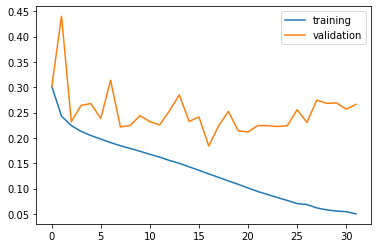

In [21]:
%matplotlib inline

plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

name = "model6_epoch32_1"
plt.savefig('../result/loss/' + name + '.png', dpi=200)

plt.show()

# Evaluation

## evaluation tools

In [22]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

%matplotlib inline

def plot_confusion_matrix(y_true, y_pred, classes, name,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.savefig('../result/confusion_matrix/' + name + '.png', dpi=200)
    return ax

In [23]:
def predict_on_df(model, df):
    dg = DataGenerator(df, batch_size=32, shuffle=False)
    yhat = model.predict_generator(dg)
    pred_index = yhat.argmax(axis=1)
    pred_conf = yhat.max(axis=1)
    df['pred_index'] = pred_index
    df['pred_label'] = df.pred_index.apply(lambda x: list(label_map.keys())[x])
    df['pred_conf'] = pred_conf
    df['match'] = df['pred_index'] == df['label']
    return df


def display_top_losses(prediction_df, k: int = 10):
    wrong_condition = ~prediction_df.match
    wrong_df = prediction_df[wrong_condition]
    return wrong_df.sort_values('pred_conf', ascending=False).iloc[0:k][['equation', 'pred_label', 'source', 'pred_index', 'label', 'pred_conf']]
    
def predict_from_str(equation, model, tokenizer):
    X = np.array([encode_sequence(equation, tokenizer)])
    yhat = model.predict(X)
    pred_index = yhat.argmax()
    label = [label for label, i in label_map.items() if i==pred_index][0]
    return {
        'yhat': yhat.tolist(),
        'pred_index': pred_index,
        'label': label
           }

## evaluate

In [24]:
test_df

,equation,post_id,score,source,type,user_id,seq,length,label
52,"g=((g_{11},0),(0,g_{22}))",140506,0,physics.stackexchange.com,Comments,5374.0,"[1, 278, 118, 72, 72, 278, 78, 31, 46, 46, 194...",27,0
176,"\text{det}\, a=\exp{(\text{tr}\ln{a})}",141110,0,physics.stackexchange.com,Comments,10522.0,"[1, 94, 139, 313, 246, 139, 31, 219, 313, 139,...",40,0
177,\delta \mathcal {L},141110,0,physics.stackexchange.com,Comments,10522.0,"[1, 94, 219, 313, 205, 139, 308, 273, 94, 123,...",21,0
268,u^{\alpha}v^{\beta},141435,0,physics.stackexchange.com,Comments,26299.0,"[1, 196, 293, 31, 94, 308, 205, 269, 101, 308,...",21,0
293,"\delta J_z = i\delta t\cdot [H,J_z]/ \hbar",141476,0,physics.stackexchange.com,Comments,1236.0,"[1, 94, 219, 313, 205, 139, 308, 273, 50, 78, ...",44,0
327,\Delta\left(\frac{d\psi}{dx}\right)=\frac{-2ma...,141555,0,physics.stackexchange.com,Comments,12719.0,"[1, 94, 22, 313, 205, 139, 308, 94, 205, 313, ...",65,0
441,(\Lambda^\mu_\nu),141849,0,physics.stackexchange.com,Comments,25706.0,"[1, 72, 94, 71, 308, 123, 95, 219, 308, 293, 9...",19,0
502,6.3 \times 10^{-3},141986,1,physics.stackexchange.com,Comments,NaN,"[1, 226, 208, 294, 273, 94, 139, 216, 123, 313...",20,0
503,6.3 \times 10^{-3}\ \mathrm{N},141986,1,physics.stackexchange.com,Comments,NaN,"[1, 226, 208, 294, 273, 94, 139, 216, 123, 313...",32,0
643,Pu_n(x) = u_n(-x)=u_n(x),142413,0,physics.stackexchange.com,Comments,6316.0,"[1, 210, 196, 78, 102, 72, 246, 242, 273, 118,...",26,0


In [25]:
predictions = predict_on_df(model, test_df)

/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [26]:
test_df

,equation,post_id,score,source,type,user_id,seq,length,label,pred_index,pred_label,pred_conf,match
52,"g=((g_{11},0),(0,g_{22}))",140506,0,physics.stackexchange.com,Comments,5374.0,"[1, 278, 118, 72, 72, 278, 78, 31, 46, 46, 194...",27,0,0,physics.stackexchange.com,0.999755,True
176,"\text{det}\, a=\exp{(\text{tr}\ln{a})}",141110,0,physics.stackexchange.com,Comments,10522.0,"[1, 94, 139, 313, 246, 139, 31, 219, 313, 139,...",40,0,0,physics.stackexchange.com,0.999998,True
177,\delta \mathcal {L},141110,0,physics.stackexchange.com,Comments,10522.0,"[1, 94, 219, 313, 205, 139, 308, 273, 94, 123,...",21,0,0,physics.stackexchange.com,0.999996,True
268,u^{\alpha}v^{\beta},141435,0,physics.stackexchange.com,Comments,26299.0,"[1, 196, 293, 31, 94, 308, 205, 269, 101, 308,...",21,0,0,physics.stackexchange.com,0.999996,True
293,"\delta J_z = i\delta t\cdot [H,J_z]/ \hbar",141476,0,physics.stackexchange.com,Comments,1236.0,"[1, 94, 219, 313, 205, 139, 308, 273, 50, 78, ...",44,0,0,physics.stackexchange.com,0.971817,True
327,\Delta\left(\frac{d\psi}{dx}\right)=\frac{-2ma...,141555,0,physics.stackexchange.com,Comments,12719.0,"[1, 94, 22, 313, 205, 139, 308, 94, 205, 313, ...",65,0,0,physics.stackexchange.com,0.979818,True
441,(\Lambda^\mu_\nu),141849,0,physics.stackexchange.com,Comments,25706.0,"[1, 72, 94, 71, 308, 123, 95, 219, 308, 293, 9...",19,0,0,physics.stackexchange.com,0.999984,True
502,6.3 \times 10^{-3},141986,1,physics.stackexchange.com,Comments,NaN,"[1, 226, 208, 294, 273, 94, 139, 216, 123, 313...",20,0,1,chemistry.stackexchange.com,0.952218,False
503,6.3 \times 10^{-3}\ \mathrm{N},141986,1,physics.stackexchange.com,Comments,NaN,"[1, 226, 208, 294, 273, 94, 139, 216, 123, 313...",32,0,0,physics.stackexchange.com,0.857921,True
643,Pu_n(x) = u_n(-x)=u_n(x),142413,0,physics.stackexchange.com,Comments,6316.0,"[1, 210, 196, 78, 102, 72, 246, 242, 273, 118,...",26,0,0,physics.stackexchange.com,0.999981,True


In [124]:
# test_df = test_df[test_df['pred_index']!=2]

Confusion matrix, without normalization
[[30572  1837]
 [  891  3306]]


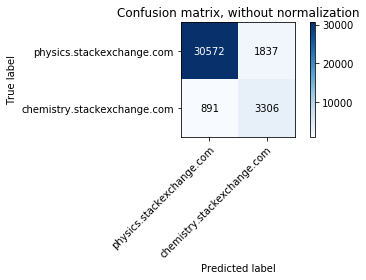

In [27]:
name = "model6_epoch32_1"
plot_confusion_matrix(predictions.label, predictions.pred_index, np.array(list(label_map.keys())), name)


Normalized confusion matrix
[[0.94331821 0.05668179]
 [0.2122945  0.7877055 ]]


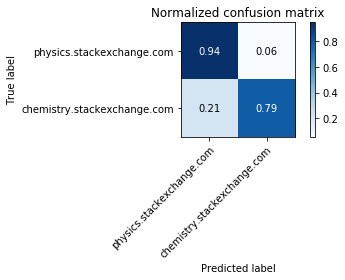

In [28]:
name = "model6_epoch32_2"
plot_confusion_matrix(predictions.label, predictions.pred_index, np.array(list(label_map.keys())), name, normalize=True)


In [29]:
predict_from_str('H\PSI = E\PSI', model, tokenizer)

{'yhat': [[0.00919194333255291, 0.9908043146133423, 3.837385065708077e-06]],
 'pred_index': 1,
 'label': 'chemistry.stackexchange.com'}

In [30]:
display_top_losses(predictions, 20)

,equation,pred_label,source,pred_index,label,pred_conf
1272833,f(\mathbf{G})-\mathcal{E}_{\mathbf{G}}=\epsilon,physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.0
1335331,\frac{[p_j]^\ddagger}{\sum_i [p_i]^\ddagger},physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.0
1267805,"\theta \in \left[ 0,2\pi \right)",physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.0
1280039,R^{*}=C\times \rho ^{*},physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.0
1280295,m_x=n_x\cdot FW_x\ \ \ \ \ (4),physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.0
1295538,(\frac 43 \pi r^{3}),physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.0
1209736,S(R) = -k_{B} \frac{ 3R^{2} }{ 2N l^{2} } + const,physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.0
1229974,\sin \alpha = \frac{S}{U},physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.0
1318293,dQ = (I^2 R)dt = VI dt,physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.0
1228069,(1\ \mathrm{kg\ m^2\ s^{-2}}=1\ \mathrm J),physics.stackexchange.com,chemistry.stackexchange.com,0,1,1.0
